# COVID-19 Final Project
### Elda Pere

The purpose of the model in this notebook is to predict how changes in policy or in other developments affect COVID-19 death rates of counties across the United States. 
<br>
<br>
**Questions to Address:**
<br>
• Given the current data set, which U.S. counties provide the best information to include in this study?
<br>
• Which features have the highest correlation to the number of COVID-19 death cases?
<br>
• What are the best ways to implement and evaluate a model that predicts COVID-19 death cases? 
<br>
<br>
**Objectives:** 
<br>
• Clean the data sets until all missing values are accounted for and unnecessary columns are removed.
<br>
• Perform exploratory data analysis on county-level data to find variables that are correlated to the latest number of deaths. 
<br>
• Use those features to predict the number of deaths in the future. 
<br>
<br>
**Sources:** 
<br>
The data sets used can be found in the links below. The granularity is at the county level for each of the data sets and they have been updated until May 5th, 2020. The data is relevant to this study because they provide information about county details such as populations by demographic, as well as COVID-19 cases and deaths. 

## Preliminary Work

Let us first import all of the libraries and CSV's that could be useful throughout this notebook.

In [12]:
#Importing basic python packages used throughout the notebook.

import numpy as np
import pandas as pd
import geopandas as gpd
import regex as re

In [13]:
#Importing packages used for mapping.

from shapely.geometry import Point
from geopandas import GeoDataFrame

In [14]:
#Importing visualization packages.

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        palette = 'Reds',
        font_scale = 1.5)


In [15]:
#Importing sklearn modules used for modeling.

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [16]:
#Importing COVID-19 csv files.

county_details = pd.read_csv('county_data_abridged.csv')
latest_state_cases = pd.read_csv('05-05-2020.csv')
county_confirmed_cases = pd.read_csv('time_series_covid19_confirmed_US.csv')
county_death_cases = pd.read_csv('time_series_covid19_deaths_US.csv')

county_confirmed_cases.shape, county_details.shape

((3261, 116), (3244, 87))

In [17]:
#To understand the dataframe. 

print("The column descriptions of the county_details table can be found here: ")
print("https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md")
print("\nThe column descriptions of latest_state_cases, county_confirmed_cases and county_death_cases can be found here: ")
print("https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/README.md")

The column descriptions of the county_details table can be found here: 
https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md

The column descriptions of latest_state_cases, county_confirmed_cases and county_death_cases can be found here: 
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/README.md


## Data Cleaning and EDA

In [18]:
county_details.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0


The primary key between the data sets will be the **County-State FIPS** code (countyFIPS here), and the secondary key will be the **State FIPS** code (the first two digits of County-State code). Since we are looking at distinct US counties and since each county has its own FIPS code, below we will remove entries that do not contain the code. 

In [19]:
#Limits the dataframe to counties with a FIPS code. 
county_details = county_details[county_details["countyFIPS"].str.match('\d{5}')]

Since the STATEFP and COUNTYFP information is contained within countyFIPS (see documentation), we will drop those columns.

In [20]:
#Updates the dataframe by dropping "STATEFP" and "COUNTYFP".
county_details = county_details.drop(['STATEFP', 'COUNTYFP'], axis = 1)

In this dataframe, lat and lon correspond to the geographic county centers, and POP_LATITUDE and POP_LONGITUDE correspond to the population centers. Since COVID-19 is known to spread through human contact, it makes more sense to use population centers. The code below drops the lat and lon columns and renames POP_LATITUDE and POP_LONGITUDE to Latitude and Longitude. 

In [21]:
#Updates the dataframe by dropping and renaming columns.
county_details = county_details.drop(['lat', 'lon'], 
                                     axis = 1).rename(columns = {"POP_LATITUDE": 'Latitude', 'POP_LONGITUDE': 'Longitude'})

The cell below checks if the data includes locations outside of the United States and its territories using GeoPandas. It outputs a map of North America with a dot for every county represented. 

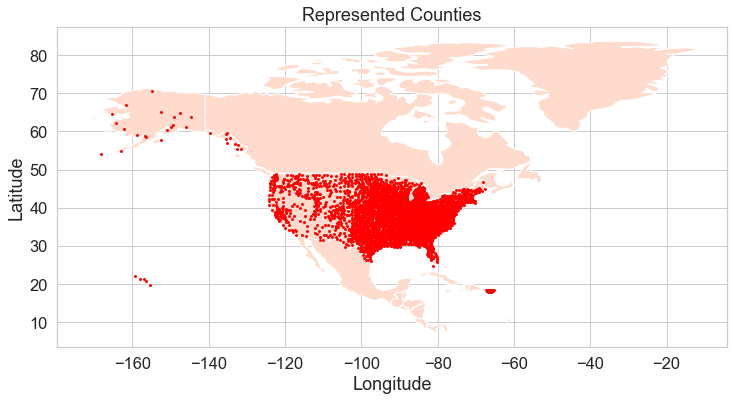

In [22]:
#Creating table for geoplotting.
geometry = [Point(xy) for xy in zip(county_details['Longitude'], county_details['Latitude'])]
gdf = GeoDataFrame(county_details, geometry=geometry)   

#Plotting the counties in county_details over an imported plot of North America. 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world[world.continent == 'North America'].plot(figsize=(12, 8)), marker='.', color='red', markersize=15);
ax.set_title('Represented Counties');
ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');

The counties in Alaska, Hawaii and U.S. territories would add a bias to this study because traveling to these locations requires different means and  prices than traveling in the mainland (see visualization above). The following block of code removes those locations.

In [23]:
#Updates the dataframe limiting it to mainland counties only. 
boolExp = county_details['StateName'].str.contains('AK|VI|HI|PR|MP|GU|AS') == False
county_details = county_details[boolExp]

Finally, we will join county_confirmed_cases and county_death_cases to county_details, in order to match COVID-19 confirmed/death cases to the features of each county for later use. 

In [24]:
#Making sure that we have distinct countyFIPS codes so that it can be used as a primary key.

county_details.shape[0] == county_details["countyFIPS"].unique().shape[0]

True

In [25]:
#Joining data with county_confirmed_cases to include COVID-19 data after matching joint column data types. 
confirmed_with_details = county_details.astype({'countyFIPS': 'float64'}).merge(county_confirmed_cases, how='inner', 
                                         left_on='countyFIPS', 
                                         right_on='FIPS',
                                         suffixes=('','_confirmed'))

In [26]:
#Joining data with county_death_cases to include COVID-19 data after matching joint column data types. 
death_with_details = county_details.astype({'countyFIPS': 'float64'}).merge(county_death_cases, how='inner', 
                                         left_on='countyFIPS', 
                                         right_on='FIPS',
                                         suffixes=('','_death'))

### Dealing with Missing Values

Below, we use a bar plot to visualize how many missing values each column contains. Some columns are almost entirely empty, while others that have fewer missing values will be explored for non-response bias. 

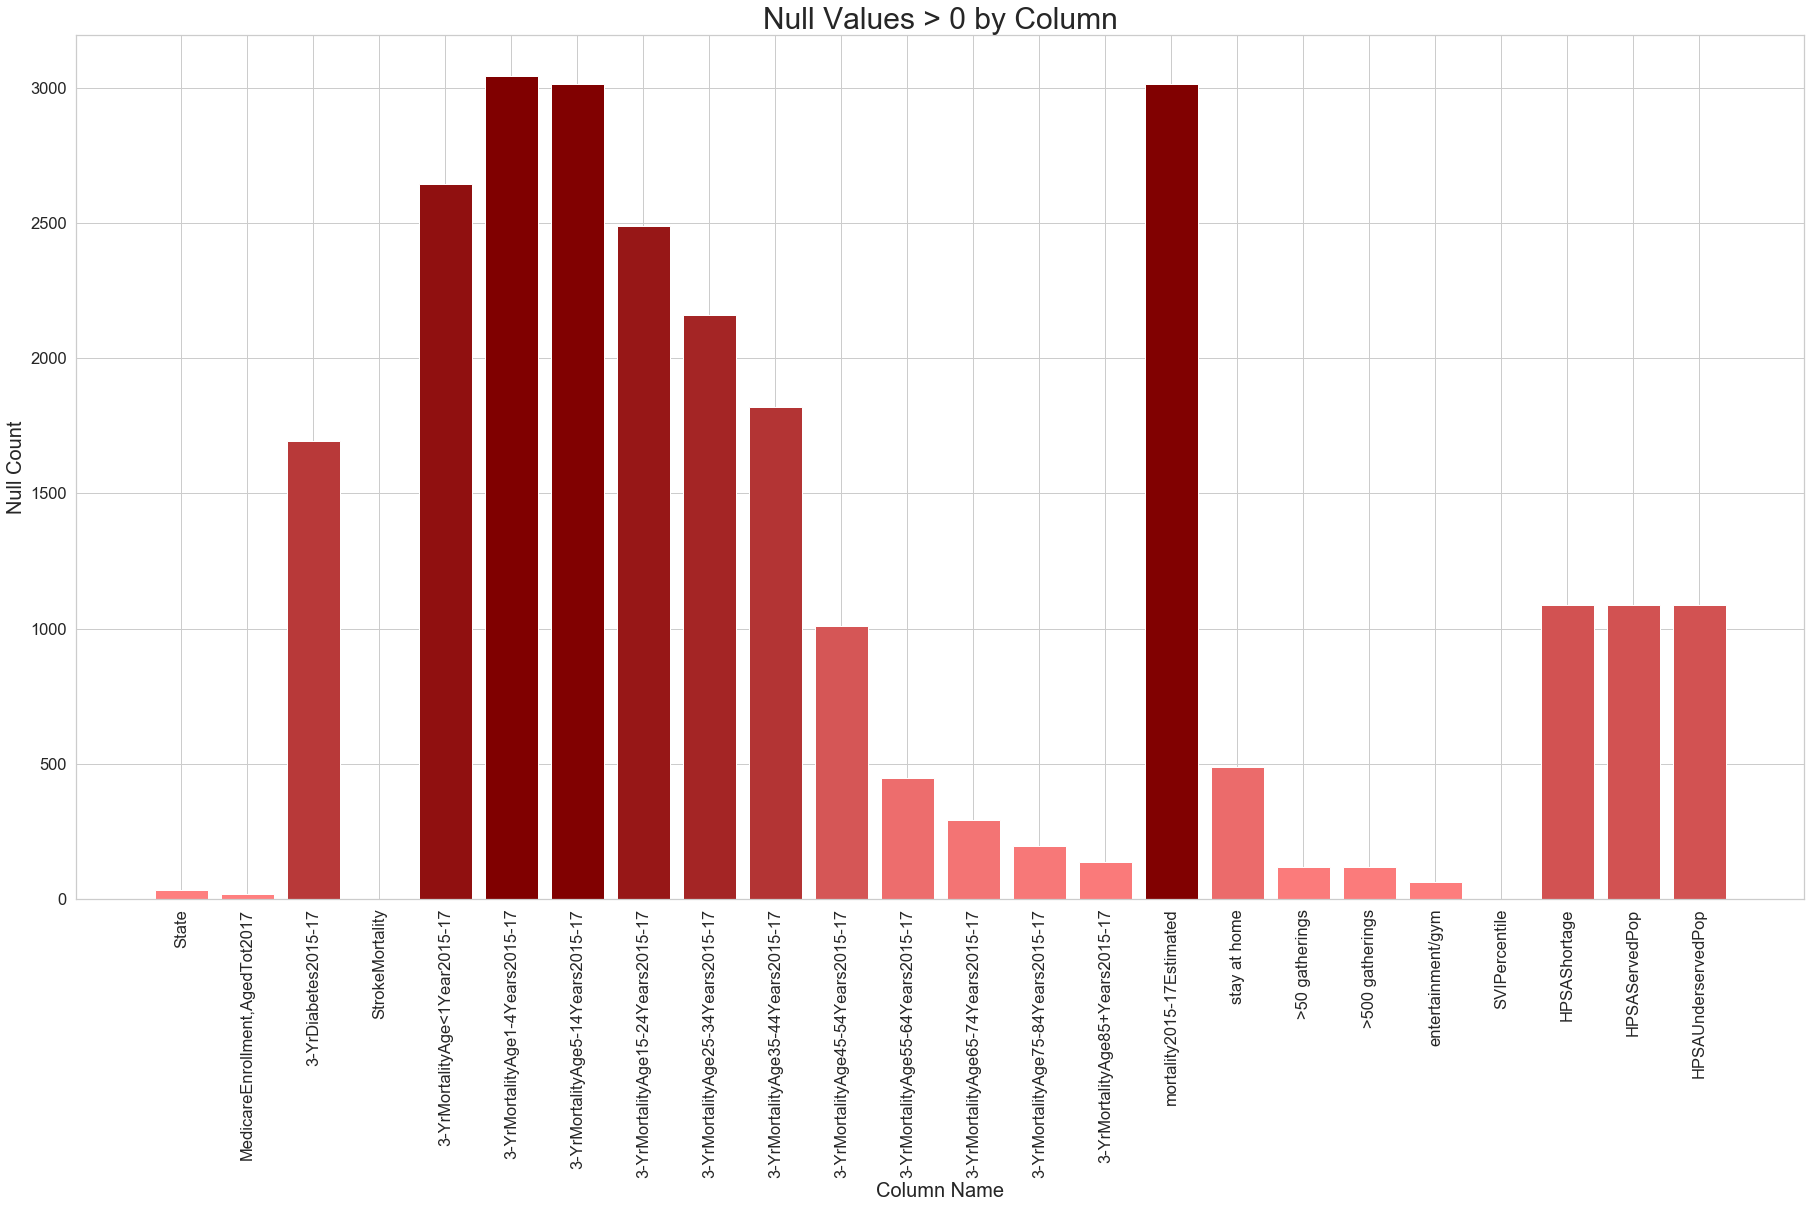

In [27]:
#Visualizing missing values with a bar plot colored by value.

#Creating the dataframe of null value counts for each column.
null_vals = pd.DataFrame(confirmed_with_details.isnull().sum())
null_vals = null_vals[null_vals[0] > 0]

#Setting up gradient colorization.
likeability_scores = np.array(null_vals[0])
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

#Plotting the bar chart of null values > 0.
fig = plt.figure();
ax = fig.add_axes([0,0,4,3]);
ax.bar(null_vals.index, null_vals[0], color=color_map(data_normalizer(likeability_scores)));
ax.set_title("Null Values > 0 by Column", fontsize = 30);
ax.set_xlabel("Column Name", fontsize = 20);
ax.set_ylabel("Null Count", fontsize = 20);
plt.xticks(rotation='vertical');

In [28]:
#Number of rows for both dataframes. 
confirmed_with_details.shape[0], death_with_details.shape[0]

(3107, 3107)

After examining the visualization, I noticed each of the columns shown came from the county_details data in both tables.
Both confirmed_with_details and death_with_details have 3107 rows, as seen above. I will remove the columns that have over 500 null values because they constitute too large a part of the overall column data. In addition, the "State" column above will be removed because "StateName" provides the same information.

In [29]:
#Finding the names of columns with over 500 missing values.
drop_names = null_vals[null_vals[0] > 500].index

#Dropping DROP_NAMES from each dataframe.
confirmed_with_details = confirmed_with_details.drop(drop_names, axis = 1).drop(['State'], axis = 1)
death_with_details = death_with_details.drop(drop_names, axis = 1).drop(['State'], axis = 1)

For the remaining cells with missing data, we will check to see how they compare to the entirety of each dataframe in terms of COVID-19 latest death numbers - both because that relates to our goal and because the latest case numbers (5/5/20) has no reported missing values in either dataframe.

In [30]:
#First verifying that there are no missing values in the latest confirmed/death cases.
x = confirmed_with_details[["5/5/20"]].isnull().sum().iloc[0]
y = death_with_details[["5/5/20"]].isnull().sum().iloc[0]
(x == 0, y == 0, x == y)

(True, True, True)

In [31]:
#Summary statistics of death_with_details.
fig1 = death_with_details[["5/5/20"]].describe()
fig1

,5/5/20
count,3107.000000
mean,22.604763
std,355.851281
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,19067.000000


In [32]:
#Summary statistics of the missing values in death_with_details.
fig2 = death_with_details[death_with_details.isnull().T.any().T][["5/5/20"]].describe()
fig2.rename(columns = {"5/5/20": "5/5/20 - Null Values"})

,5/5/20 - Null Values
count,773.000000
mean,0.908150
std,4.027509
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,53.000000


Based on the summary statistics above, the mean of the rows with missing data is significantly smaller than the mean of the rest of the dataframe. Below, we will explore ways of incorporating that missing data into our dataframes so that no information is lost. 

In [33]:
#We are interested in checking latitude/longitude for possible patterns, but we must first 
# verify that those columns have no missing values that could corrupt our analysis.

x = death_with_details[["Longitude"]].isnull().sum().iloc[0]
y = death_with_details[["Longitude"]].isnull().sum().iloc[0]
(x == 0, y == 0, x == y)

(True, True, True)

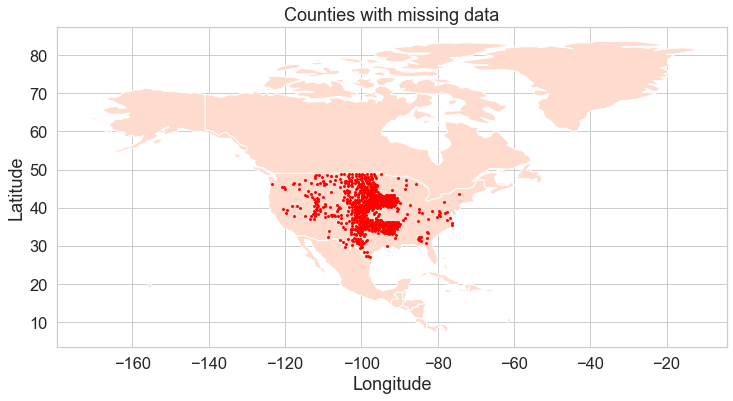

In [34]:
#Plot to check for patterns/possible bias in the rows with missing information.
# It seems they are all located in the middle of the country with varying latitude but similar longitude. 

#Creating table for geoplotting.
counties_with_missing_data = death_with_details[death_with_details.isnull().T.any().T]
geometry = [Point(xy) for xy in zip(counties_with_missing_data['Longitude'], counties_with_missing_data['Latitude'])]
gdf = GeoDataFrame(counties_with_missing_data, geometry=geometry)   

#Plotting the counties with missing values over an imported plot of North America. 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world[world.continent == 'North America'].plot(figsize=(12, 8)), marker='.', color='red', markersize=15);
ax.set_title('Counties with missing data');
ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');

To incorporate the missing data above to our dataframe, we will replace the missing cell values with the average of the cells within one standard deviation of the mean longitude of all missing cells. After this step, there should be no more missing values.

In [35]:
#Column names with missing data, used in the following code blocks.

m = pd.DataFrame(confirmed_with_details.isnull().sum())
m = m[m[0] > 0]
missing_data_columns = m.index
missing_data_columns

Index(['MedicareEnrollment,AgedTot2017', 'StrokeMortality',
       '3-YrMortalityAge55-64Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17',
       'stay at home', '>50 gatherings', '>500 gatherings',
       'entertainment/gym', 'SVIPercentile'],
      dtype='object')

In [36]:
#Finding mean and standard deviation values of longitude for each dataframe of missing values.
confirmed_lon_mean = confirmed_with_details[confirmed_with_details.isnull().T.any().T][["Longitude"]].mean().iloc[0]
death_lon_mean = death_with_details[death_with_details.isnull().T.any().T][["Longitude"]].mean().iloc[0]
confirmed_lon_std = confirmed_with_details[confirmed_with_details.isnull().T.any().T][["Longitude"]].std().iloc[0]
death_lon_std = death_with_details[death_with_details.isnull().T.any().T][["Longitude"]].std().iloc[0]

#Creating dataframes within desired longitude range (+, - one standard deviation).  
one_std_cdf = confirmed_with_details[confirmed_with_details['Longitude'] > (confirmed_lon_mean - confirmed_lon_std)]
one_std_cdf = confirmed_with_details[confirmed_with_details['Longitude'] < (confirmed_lon_mean + confirmed_lon_std)]

one_std_ddf = death_with_details[death_with_details['Longitude'] > (death_lon_mean - death_lon_std)]
one_std_ddf = death_with_details[death_with_details['Longitude'] < (death_lon_mean + death_lon_std)]


In [37]:
#Replacing the missing values with appropriate column means.
for i in missing_data_columns:
    confirmed_with_details[[i]] = confirmed_with_details[[i]].fillna(one_std_cdf[i].mean(), axis = 0)

for j in missing_data_columns:
    death_with_details[[j]] = death_with_details[[j]].fillna(one_std_ddf[j].mean(), axis = 0)
    
#Checking that there are no more missing values.
print("There are " + str(confirmed_with_details.isnull().sum().sum()) + " missing values in confirmed_with_details.")
print("There are " + str(death_with_details.isnull().sum().sum()) + " missing values in death_with_details.")
      

There are 0 missing values in confirmed_with_details.
There are 0 missing values in death_with_details.


### Additional EDA

Below, we will investigate how confirmed cases and death cases have changed over time. 

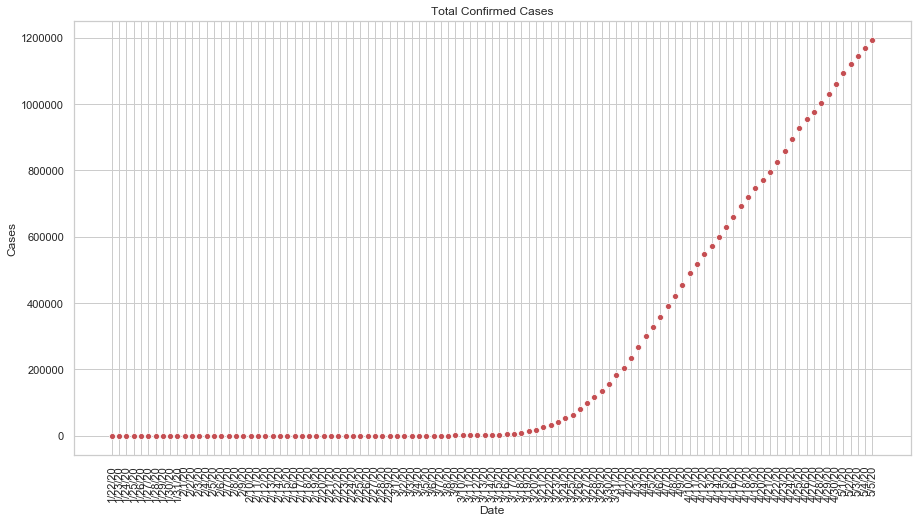

In [38]:
#Total COVID-19 confirmed cases by date.

sums = pd.DataFrame(confirmed_with_details.iloc[:,-105:].sum())
sns.set(rc={'figure.figsize':(15,8)})
sns.set(style = "whitegrid")
ax2 = sns.scatterplot(x = sums.index, y = sums[0], color = 'r')
plt.setp(ax2.get_xticklabels(), rotation=90);
ax2.set_title("Total Confirmed Cases");
ax2.set_xlabel("Date");
ax2.set_ylabel("Cases");

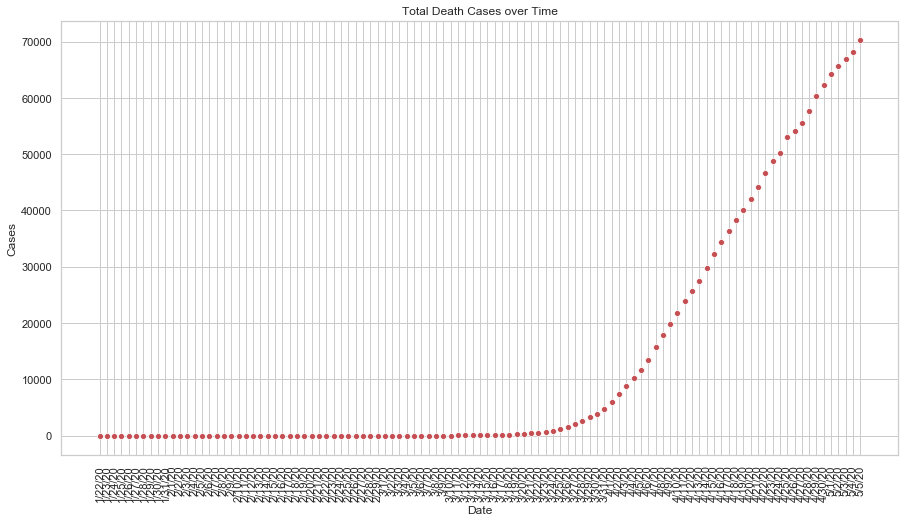

In [39]:
#Total COVID-19 death cases by date.

sums2 = pd.DataFrame(death_with_details.iloc[:,-105:].sum())
sns.set(rc={'figure.figsize':(15,8)})
sns.set(style = "whitegrid")
ax2 = sns.scatterplot(x = sums2.index, y = sums2[0], color = 'r')
plt.setp(ax2.get_xticklabels(), rotation=90);
ax2.set_title("Total Death Cases over Time");
ax2.set_xlabel("Date");
ax2.set_ylabel("Cases");

The sudden spike in confirmed cases happens toward the middle of March, while the spike in death cases happens in the end of March. Both plots seem to follow a similar trajectory, so we will plot the relationship between the two of them. 

In [40]:
#A table with deaths and confirmed cases by date. This will make it easier to plot the two against each other. 

#Selecting the date columns from death_with_details and confirmed_with_details.
case_death_by_date = pd.DataFrame(death_with_details.iloc[:,-105:].sum())
to_join = pd.DataFrame(confirmed_with_details.iloc[:,-105:].sum())

#Joining the resulting dataframes by index. 
case_death_by_date = case_death_by_date.merge(to_join, how = "inner", 
                                              left_on = case_death_by_date.index, right_on = to_join.index )
#Renaming the columns.
case_death_by_date = case_death_by_date.rename(columns = {'key_0': 'Date', '0_x': 'Deaths', '0_y': 'Confirmed'})

case_death_by_date.head()

,Date,Deaths,Confirmed
0,1/22/20,0,1
1,1/23/20,0,1
2,1/24/20,0,2
3,1/25/20,0,2
4,1/26/20,0,5


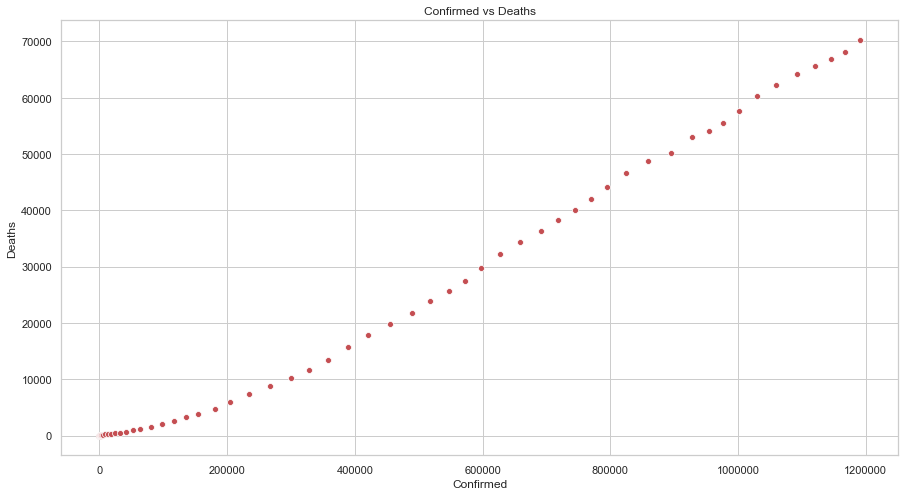

In [41]:
#Displaying the relationship between total confirmed cases and the number of deaths.
#This is done because the two plots above of confirmed cases and death cases by date looked similar.
sns.set(style = "whitegrid")

ax = sns.scatterplot(x = case_death_by_date["Confirmed"], y = case_death_by_date["Deaths"], color = 'r')

ax.set_title("Confirmed vs Deaths");

Finally, we will use a combination of this data as part of our covariates for predicting deaths. In the cell below, we join the death_with_details dataframe to the latest confirmed cases (5/5/20 in confirmed_with_details) because of the relationship above. 

In [42]:
#Concatening county and state fields because many counties have similar names and makes for a bad index. 
confirmed_with_details['CountyName'] = confirmed_with_details[['CountyName', 'StateName']].agg('-'.join, axis=1)
death_with_details['CountyName'] = death_with_details[['CountyName', 'StateName']].agg('-'.join, axis=1)

#Merging death_with_details to latest confirmed cases in confirmed_with_details using "CountyName" as a primary key. 
merged_data = death_with_details.merge(confirmed_with_details[["CountyName", "5/5/20"]], 
                                          how = "left", left_on = "CountyName", 
                                          right_on = "CountyName", 
                                          suffixes=('_deaths','_confirmed'))

merged_data = merged_data[merged_data['5/5/20_deaths'] < 10000]         #removing an outlier

## Modeling the Data

Now that we have come up with a clean dataset that has relevant columns for predicting death cases, we may begin choosing features that have significant correlation to "5/5/20_deaths" and training our model. 

In [43]:
#Splitting the training set and testing set.

tr, te = train_test_split(merged_data, test_size=0.1, random_state=83)
tr.head()

,countyFIPS,CountyName,StateName,Latitude,Longitude,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20_deaths,5/5/20_confirmed
1206,26023.0,Branch-MI,MI,41.929764,-85.031761,Midwest,East North Central,6.0,43622.0,22383.0,...,2,2,2,2,2,2,2,2,2,70
672,18023.0,Clinton-IN,IN,40.298201,-86.512307,Midwest,East North Central,6.0,32250.0,16110.0,...,1,1,1,1,1,1,1,1,1,65
1066,21219.0,Todd-KY,KY,36.811760,-87.171454,South,East South Central,8.0,12311.0,6088.0,...,0,0,0,0,0,0,0,0,0,13
1233,26077.0,Kalamazoo-MI,MI,42.263480,-85.584896,Midwest,East North Central,2.0,264870.0,128831.0,...,12,12,12,13,18,18,18,22,22,489
3048,55077.0,Marquette-WI,WI,43.813741,-89.411070,Midwest,East North Central,8.0,15434.0,7798.0,...,1,1,1,1,1,1,1,1,1,3


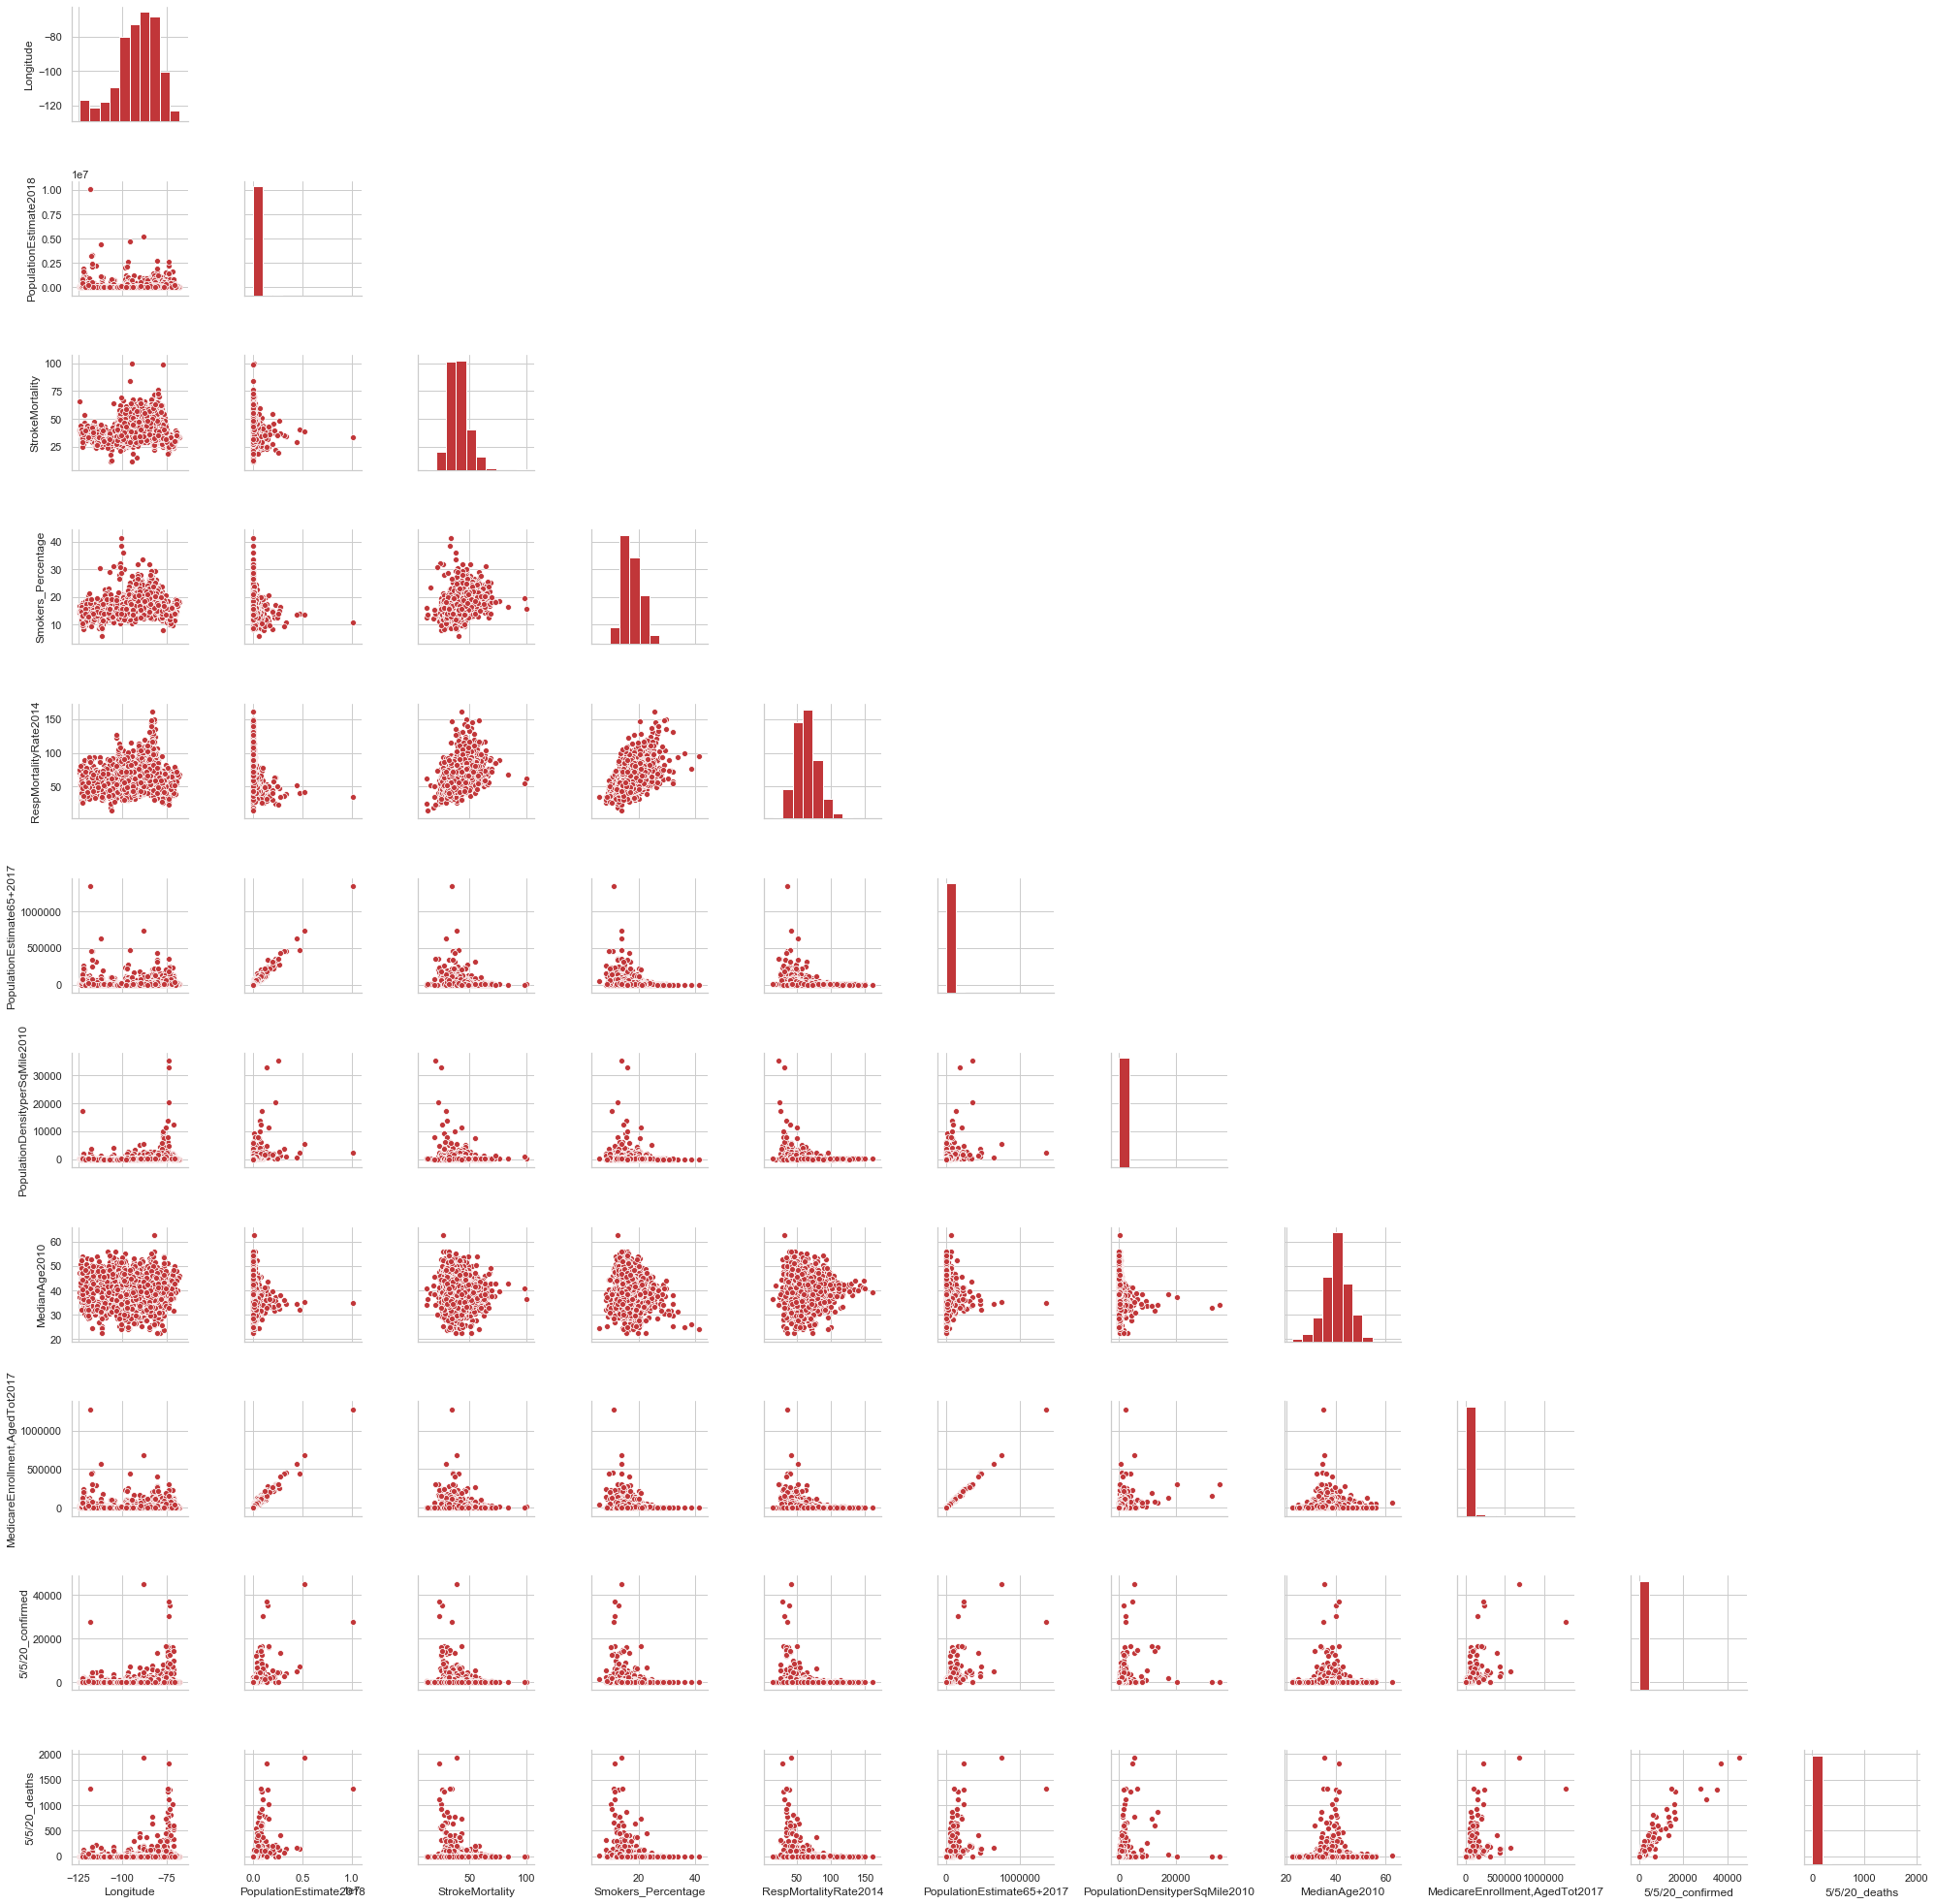

In [44]:
#We will use the following pairplot to gauge the features that have the 
# highest correlation to the COVID-19 death cases. 

#List of features to be plotted against each other.
pairplot_list = ["Longitude", "PopulationEstimate2018",
                          "StrokeMortality", "Smokers_Percentage",
                          "RespMortalityRate2014", "PopulationEstimate65+2017", 
                          "PopulationDensityperSqMile2010", "MedianAge2010",
                          "MedicareEnrollment,AgedTot2017", "5/5/20_confirmed", 
                          "5/5/20_deaths"]

#Continues the style used in this notebook.
sns.set(style = "whitegrid")
sns.set_palette("RdBu")

#Plots the data in pairplot_list.
ax = sns.pairplot(tr[pairplot_list]);

#Hides repetitions of the same pairs.
for i, j in zip(*np.triu_indices_from(ax.axes, 1)):
    ax.axes[i, j].set_visible(False)

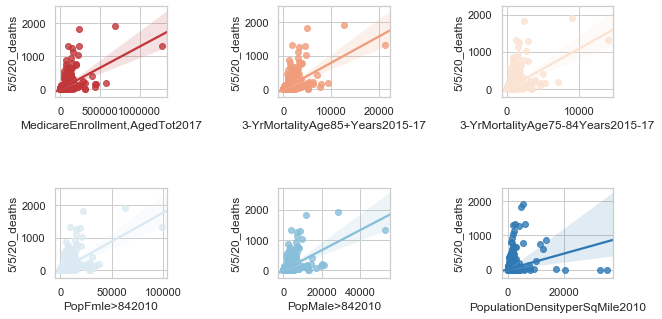

In [45]:
#General look at other columns vs death tolls to choose features.

#Feature list
features = ["5/5/20_confirmed", "Longitude", 
            'MedicareEnrollment,AgedTot2017', "PopulationDensityperSqMile2010",
           '3-YrMortalityAge85+Years2015-17', '3-YrMortalityAge75-84Years2015-17', 'PopFmle>842010',
            'PopMale>842010']

#Preparing subplots
fig, ax = plt.subplots(figsize=(10,5), ncols=3, nrows=2);
plt.subplots_adjust(wspace=1, hspace=1);

sns.regplot(x='MedicareEnrollment,AgedTot2017', y='5/5/20_deaths', data=tr, ax=ax[0][0]);
sns.regplot(x= '3-YrMortalityAge85+Years2015-17', y='5/5/20_deaths', data=tr, ax=ax[0][1]);
sns.regplot(x= '3-YrMortalityAge75-84Years2015-17', y='5/5/20_deaths', data=tr, ax=ax[0][2]);
sns.regplot(x= 'PopFmle>842010', y='5/5/20_deaths', data=tr, ax=ax[1][0]);
sns.regplot(x= 'PopMale>842010', y='5/5/20_deaths', data=tr, ax=ax[1][1]);
sns.regplot(x= "PopulationDensityperSqMile2010", y='5/5/20_deaths', data=tr, ax=ax[1][2]);

After looking at the plots above and testing the features in the pipeline below, the following features will be used for the testing and training sets because of their noticable correlation to the number of deaths ("5/5/20_deaths"), compared to other features.

In [46]:
#Setting X_train and X_test to the best features. 
X_train = tr[["5/5/20_confirmed", "Longitude", "PopulationEstimate2018", "MedicareEnrollment,AgedTot2017", "PopulationDensityperSqMile2010", "CensusRegionName"]]
X_test = te[["5/5/20_confirmed", "Longitude", "PopulationEstimate2018", "MedicareEnrollment,AgedTot2017", "PopulationDensityperSqMile2010", "CensusRegionName"]]

#Setting Y_train and Y_test to the latest death numbers.
Y_train = tr[["5/5/20_deaths"]]
Y_test = te[["5/5/20_deaths"]]

We will use the Lasso model because it is less sensitive to outliers (some are seen in the plots above) and because of its feature selection property (to choose from the features above). 

In [47]:
#Import necessary modules from sklearn.
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#Choose quantitative features.
quantitative_features = ["5/5/20_confirmed", "Longitude", 
                         'MedicareEnrollment,AgedTot2017', "PopulationDensityperSqMile2010", "PopulationEstimate2018"]

#Build the pipeline.
lasso_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("origin_encoder", OneHotEncoder(), ["CensusRegionName"])
        ])),
    ("LinearModel", Lasso(alpha = 0.1))
])

In [48]:
#Fitting the training set to the model.
lasso_model.fit(X_train, Y_train)

#Predicting the Y_train values from X_train.
Y_pred = lasso_model.predict(X_train)


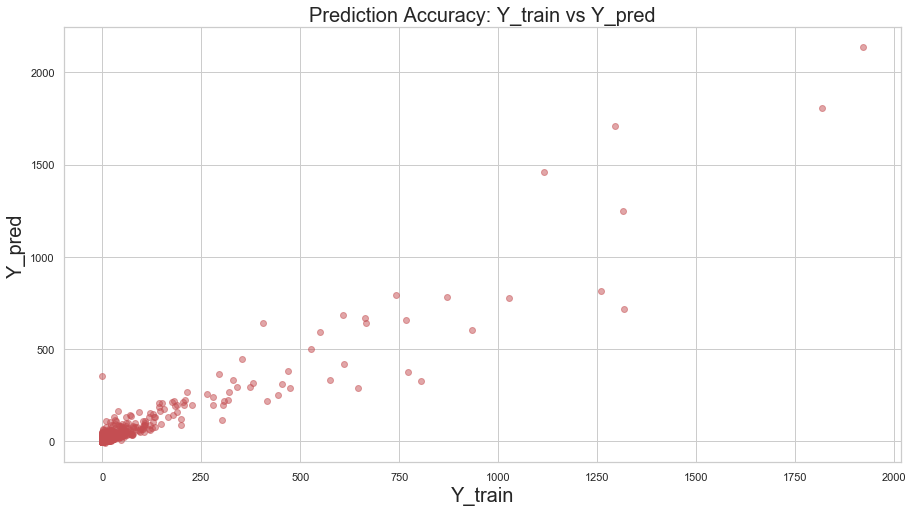

In [49]:
#Plotting the results.
ax = plt.scatter(tr[["5/5/20_deaths"]], Y_pred, alpha=0.5, color = 'r');
plt.title("Prediction Accuracy: Y_train vs Y_pred", fontsize = 20);
plt.xlabel("Y_train", fontsize = 20);
plt.ylabel("Y_pred", fontsize = 20);

## Testing the Model

To determine the accuracy of our model, we will calculate the root mean squared error of the training and test predictions, and plot the residual graph to check if there are still any patterns. 

In [52]:
#Function to calculate rmse. 

def rmse(actual_y, predicted_y):
    return (np.mean((actual_y - predicted_y)**2))**0.5

In [56]:
#Training error.

print("Training error: " + str(rmse(tr["5/5/20_deaths"], lasso_model.predict(X_train))))

Training error: 29.614055337624173


In [58]:
#Test error.

print("Testing error: " + str(rmse(te["5/5/20_deaths"], lasso_model.predict(X_test))))

Testing error: 64.53059204460558


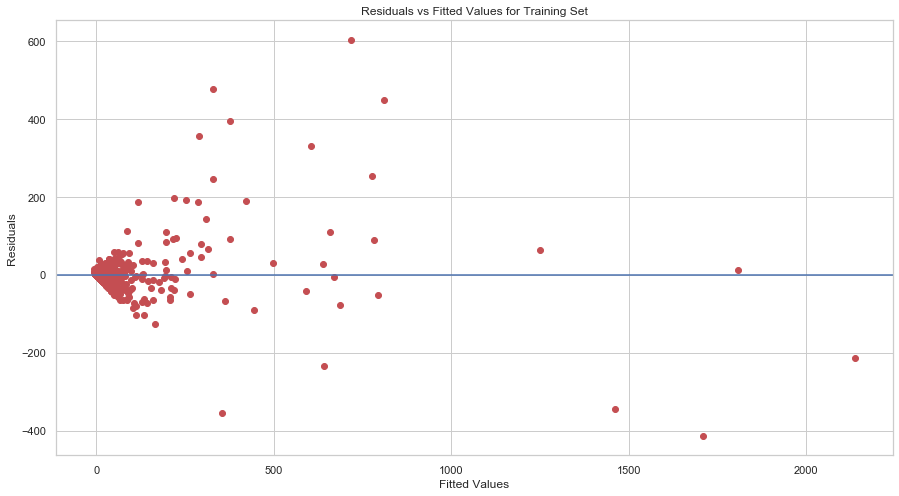

In [59]:
#Plot the residuals of the training set.

residual = np.asarray(Y_train["5/5/20_deaths"]) - lasso_model.predict(X_train)
plt.scatter(lasso_model.predict(X_train), residual, color = 'r');
plt.xlabel('Fitted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs Fitted Values for Training Set');
plt.axhline(y = 0, color = 'b');

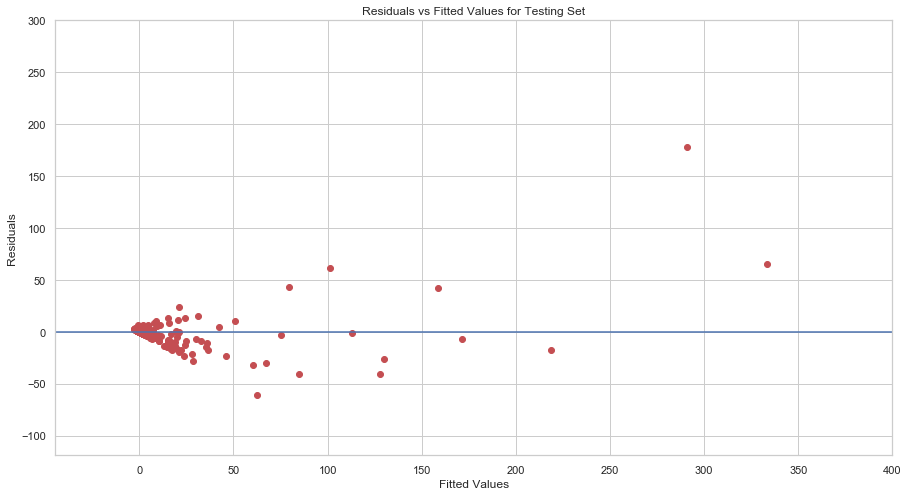

In [60]:
#Plot the residuals of the test set.

residuals = np.asarray(Y_test["5/5/20_deaths"]) - lasso_model.predict(X_test)
plt.scatter(lasso_model.predict(X_test), residuals, color = 'r');
plt.xlabel('Fitted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs Fitted Values for Testing Set');
plt.axhline(y = 0, color = 'b');
plt.xlim(right = 400);
plt.ylim(top = 300);

Aside from the single point above 1000 in the test set, the rest of the residuals seem to center around the y = 0 line with no particular pattern, although the vertical spread varies. Regardless, for this model we will conclude that it has properly fit the data and drawn reasonable predictions for Y values - the number of deaths in a county compared to other features. In the future, we will be able to use this model to predict rises or falls in deaths as developments cause features such as Medicare Enrollment or Population Density to change. 

### Thank you!